<a href="https://colab.research.google.com/github/yurizza/Home-Credit-Default-Risk/blob/main/HCI_Data_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Score Card Model

Business Problem:
Perusahaan pemberi pinjaman (Home Credit) menghadapi tantangan dalam menilai risiko kredit untuk calon peminjam. Untuk meningkatkan keputusan kredit, perusahaan ingin mengimplementasikan model machine learning yang dapat memprediksi kemampuan pelanggan untuk membayar pinjaman berdasarkan data historis dan atribut lainnya.

Objectives: Pembuatan model prediksi menggunakan algoritma Regresi Logistik.


application_{train|test}.csv
* This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
* Static data for all applications. One row represents one loan in our data sample.

bureau_balance.csv
* Monthly balances of previous credits in Credit Bureau.
* This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows

POS_CASH_balance.csv
* Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
* This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows

previous_application.csv
* All previous applications for Home Credit loans of clients who have loans in our sample.
* There is one row for each previous application related to loans in our data sample

credit_card_balance.csv
* Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
* This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows

bureau.csv
* All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
* For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date

### Import Library

In [2]:
import os
from zipfile import ZipFile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

!pip install catboost
from catboost import CatBoostClassifier

In [3]:
folder_path = 'drive/MyDrive/rakamin/Home credit indonesia/'

In [4]:
os.listdir(folder_path)

['Dataset_Description__Task_5-2a9c29ec-455a-450e-a631-8782e792b88d.pdf',
 'home-credit-default-risk.zip',
 'HomeCredit_columns_description.csv',
 'POS_CASH_balance.csv',
 'application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'previous_application.csv',
 'sample_submission.csv',
 'HomeCredit_columns_description.gsheet',
 'df_main_train_encode.csv',
 'df_main_test_encode.csv']

In [5]:
# Extract zip file

# nama_file_zip = 'home-credit-default-risk.zip'

# with ZipFile(folder_path + nama_file_zip, 'r') as zip_ref:
#     # Mengekstrak semua file ke lokasi_extraksi
#     zip_ref.extractall(folder_path)

### Exploratory Data Analysis

#### Assesing Data

In [6]:
def hitung_null_persentase(df):
    # Hitung jumlah nilai null per kolom
    null_counts = df.isnull().sum()

    # Hitung persentase nilai null per kolom
    total_rows = len(df)
    null_percentages = (null_counts / total_rows) * 100

    # Gabungkan hasil ke dalam DataFrame baru
    result_df = pd.DataFrame({
        'Jumlah_Null': null_counts,
        'Persentase_Null': null_percentages
    }).sort_values(by='Jumlah_Null', ascending=False)

    return result_df

##### application train and test

In [7]:
df_application_test = pd.read_csv(folder_path + 'application_test.csv')

df_application_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
hitung_null_persentase(df_application_test)

,Jumlah_Null,Persentase_Null
COMMONAREA_AVG,33495,68.716150
COMMONAREA_MODE,33495,68.716150
COMMONAREA_MEDI,33495,68.716150
NONLIVINGAPARTMENTS_AVG,33347,68.412523
NONLIVINGAPARTMENTS_MODE,33347,68.412523
...,...,...
NAME_HOUSING_TYPE,0,0.000000
NAME_FAMILY_STATUS,0,0.000000
NAME_EDUCATION_TYPE,0,0.000000
NAME_INCOME_TYPE,0,0.000000


In [9]:
df_application_test.duplicated().sum()

0

In [10]:
df_application_train = pd.read_csv(folder_path + 'application_train.csv')

df_application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
hitung_null_persentase(df_application_train)

,Jumlah_Null,Persentase_Null
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
...,...,...
NAME_HOUSING_TYPE,0,0.000000
NAME_FAMILY_STATUS,0,0.000000
NAME_EDUCATION_TYPE,0,0.000000
NAME_INCOME_TYPE,0,0.000000


In [12]:
df_application_train.duplicated().sum()

0

##### bureau

In [13]:
df_bureau = pd.read_csv(folder_path + 'bureau.csv')

df_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [14]:
hitung_null_persentase(df_bureau)

,Jumlah_Null,Persentase_Null
AMT_ANNUITY,1226791,71.473490
AMT_CREDIT_MAX_OVERDUE,1124488,65.513264
DAYS_ENDDATE_FACT,633653,36.916958
AMT_CREDIT_SUM_LIMIT,591780,34.477415
AMT_CREDIT_SUM_DEBT,257669,15.011932
DAYS_CREDIT_ENDDATE,105553,6.149573
AMT_CREDIT_SUM,13,0.000757
CREDIT_ACTIVE,0,0.000000
CREDIT_CURRENCY,0,0.000000
DAYS_CREDIT,0,0.000000


In [15]:
df_bureau.duplicated().sum()

0

##### bureau balance

In [16]:
df_bureau_balance = pd.read_csv(folder_path + 'bureau_balance.csv')

df_bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [17]:
hitung_null_persentase(df_bureau_balance)

,Jumlah_Null,Persentase_Null
SK_ID_BUREAU,0,0.0
MONTHS_BALANCE,0,0.0
STATUS,0,0.0


In [18]:
df_bureau_balance.duplicated().sum()

0

##### credit card balance

In [19]:
df_credit_card_balance = pd.read_csv(folder_path + 'credit_card_balance.csv')

df_credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [20]:
hitung_null_persentase(df_credit_card_balance)

,Jumlah_Null,Persentase_Null
AMT_PAYMENT_CURRENT,767988,19.998063
AMT_DRAWINGS_ATM_CURRENT,749816,19.524872
CNT_DRAWINGS_POS_CURRENT,749816,19.524872
AMT_DRAWINGS_OTHER_CURRENT,749816,19.524872
AMT_DRAWINGS_POS_CURRENT,749816,19.524872
CNT_DRAWINGS_OTHER_CURRENT,749816,19.524872
CNT_DRAWINGS_ATM_CURRENT,749816,19.524872
CNT_INSTALMENT_MATURE_CUM,305236,7.948208
AMT_INST_MIN_REGULARITY,305236,7.948208
SK_ID_PREV,0,0.000000


In [21]:
df_credit_card_balance.duplicated().sum()

0

##### installments payments

In [22]:
df_installments_payments = pd.read_csv(folder_path + 'installments_payments.csv')

df_installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [23]:
hitung_null_persentase(df_installments_payments)

,Jumlah_Null,Persentase_Null
DAYS_ENTRY_PAYMENT,2905,0.021352
AMT_PAYMENT,2905,0.021352
SK_ID_PREV,0,0.000000
SK_ID_CURR,0,0.000000
NUM_INSTALMENT_VERSION,0,0.000000
NUM_INSTALMENT_NUMBER,0,0.000000
DAYS_INSTALMENT,0,0.000000
AMT_INSTALMENT,0,0.000000


In [24]:
df_installments_payments.duplicated().sum()

0

##### previous application

In [25]:
df_previous_application = pd.read_csv(folder_path + 'previous_application.csv')

df_previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
hitung_null_persentase(df_previous_application)

,Jumlah_Null,Persentase_Null
RATE_INTEREST_PRIVILEGED,1664263,99.643698
RATE_INTEREST_PRIMARY,1664263,99.643698
AMT_DOWN_PAYMENT,895844,53.636480
RATE_DOWN_PAYMENT,895844,53.636480
NAME_TYPE_SUITE,820405,49.119754
NFLAG_INSURED_ON_APPROVAL,673065,40.298129
DAYS_TERMINATION,673065,40.298129
DAYS_LAST_DUE,673065,40.298129
DAYS_LAST_DUE_1ST_VERSION,673065,40.298129
DAYS_FIRST_DUE,673065,40.298129


In [27]:
df_previous_application.duplicated().sum()

0

##### pos cash balance

In [28]:
df_pos_cash_balance = pd.read_csv(folder_path + 'POS_CASH_balance.csv')

df_pos_cash_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [29]:
hitung_null_persentase(df_pos_cash_balance)

,Jumlah_Null,Persentase_Null
CNT_INSTALMENT_FUTURE,26087,0.260835
CNT_INSTALMENT,26071,0.260675
SK_ID_PREV,0,0.000000
SK_ID_CURR,0,0.000000
MONTHS_BALANCE,0,0.000000
NAME_CONTRACT_STATUS,0,0.000000
SK_DPD,0,0.000000
SK_DPD_DEF,0,0.000000


In [30]:
df_pos_cash_balance.duplicated().sum()

0

#### Exploratory data

In [31]:
print('Size of application_train data', df_application_train.shape)
print('Size of POS_CASH_balance data', df_pos_cash_balance.shape)
print('Size of bureau_balance data', df_bureau_balance.shape)
print('Size of previous_application data', df_previous_application.shape)
print('Size of installments_payments data', df_installments_payments.shape)
print('Size of credit_card_balance data', df_credit_card_balance.shape)
print('Size of bureau data', df_bureau.shape)

Size of application_train data (307511, 122)
Size of POS_CASH_balance data (10001358, 8)
Size of bureau_balance data (27299925, 3)
Size of previous_application data (1670214, 37)
Size of installments_payments data (13605401, 8)
Size of credit_card_balance data (3840312, 23)
Size of bureau data (1716428, 17)


##### Analysis Univariat

1. distribution of amount credit

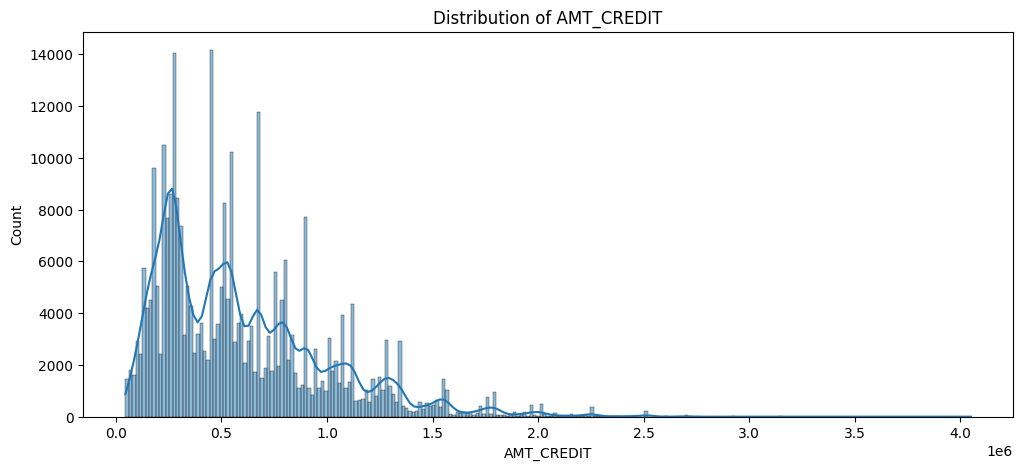

In [33]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_CREDIT")
ax = sns.histplot(df_application_train["AMT_CREDIT"], kde=True)

2.  distribution of amount goods price

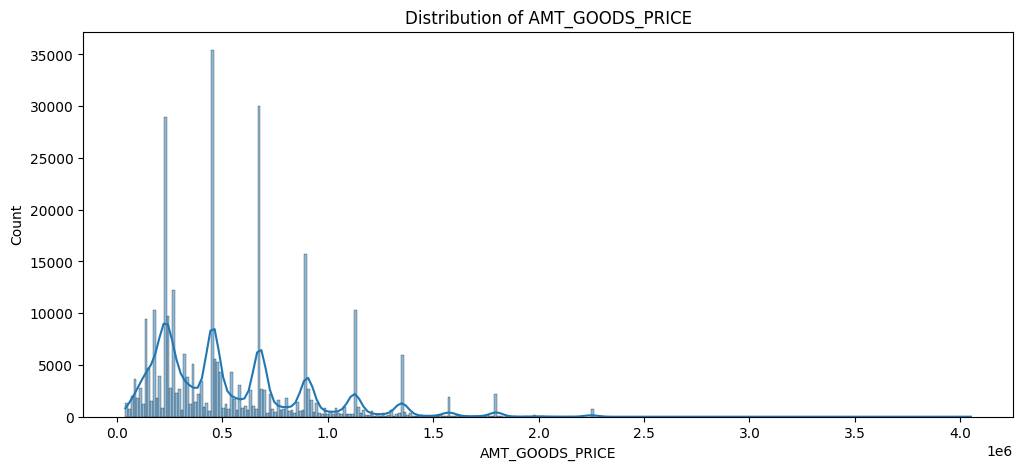

In [34]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_GOODS_PRICE")
ax = sns.histplot(df_application_train["AMT_GOODS_PRICE"].dropna(), kde = True)

3. Data is balanced or imbalanced

In [35]:
df_application_train["TARGET"].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

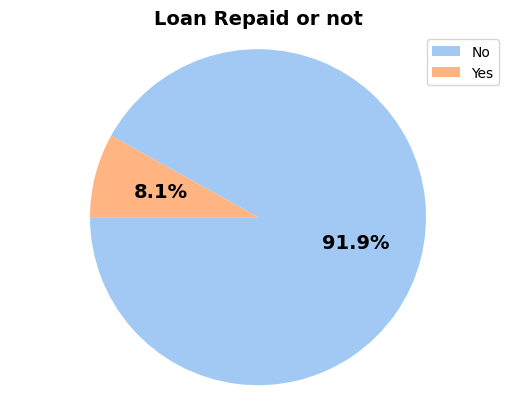

In [36]:
# Assuming df_application_train is your DataFrame
temp = df_application_train["TARGET"].value_counts()

# Create a DataFrame for plotting
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })

# Define colors
colors = ['#a1c9f4','#ffb482']
textprops={'color': 'black', 'weight': 'bold', 'fontsize': 14}

# Plotting the pie chart with specified colors
df.plot(kind='pie', y='values', labels=None, autopct='%1.1f%%', startangle=180, colors=colors,textprops=textprops)
plt.title('Loan Repaid or not',weight='bold', fontsize=14)
plt.ylabel('')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.legend(['No','Yes'])
plt.show()

Data is highly imbalanced.

4. Types of loan

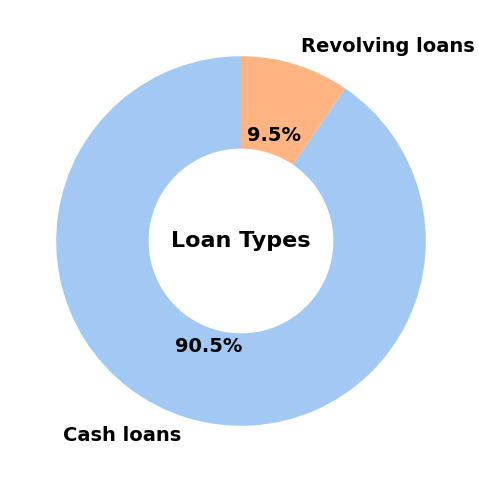

In [37]:
# Assuming application_train is your DataFrame
temp = df_application_train["NAME_CONTRACT_TYPE"].value_counts()

# Create a pie chart using Matplotlib with Seaborn styling
plt.figure(figsize=(6, 6))
plt.pie(temp, labels=temp.index, autopct='%1.1f%%', colors=colors, startangle=90, wedgeprops=dict(width=0.5), textprops=textprops)
plt.title("")  # Clear default title
# plt.legend(temp.index)
# Add a title in the center of the donut chart
plt.text(0, 0, "Loan Types", ha='center', va='center', fontsize=16, fontweight='bold')

plt.show()

Most of the loans are **Cash loans** which were taken by applicants. 90.5 % loans are Cash loans.

5. Properties that client have

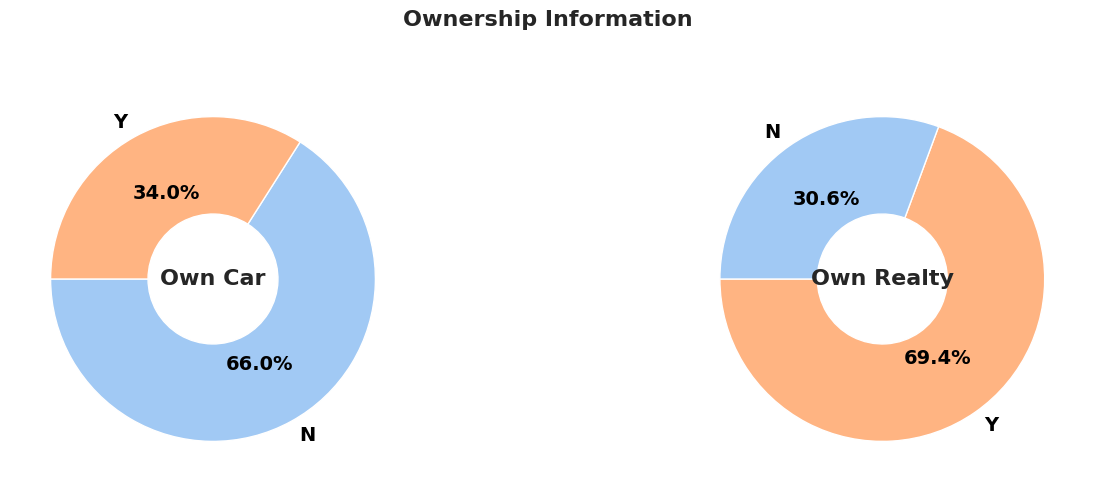

In [38]:
# Assuming application_train is your DataFrame
temp1 = df_application_train["FLAG_OWN_CAR"].value_counts()
temp2 = df_application_train["FLAG_OWN_REALTY"].value_counts()

# Set up the figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot donut charts using Seaborn
sns.set_theme()  # Set Seaborn theme

# Donut chart for Own Car
axes[0].pie(temp1, labels=temp1.index, autopct='%1.1f%%', startangle=180, wedgeprops=dict(width=0.6), colors=colors, textprops=textprops)
# Add a title in the center of the donut chart
axes[0].text(0, 0, "Own Car", ha='center', va='center', fontsize=16, fontweight='bold')

# Donut chart for Own Realty
axes[1].pie(temp2, labels=temp2.index, autopct='%1.1f%%', startangle=180, wedgeprops=dict(width=0.6), colors=[colors[1],colors[0]], textprops=textprops)
# Add a title in the center of the donut chart
axes[1].text(0, 0, "Own Realty", ha='center', va='center', fontsize=16, fontweight='bold')

# Add a title to the overall plot
fig.suptitle('Ownership Information', fontsize=16, fontweight='bold')

# Adjust layout to prevent clipping of titles
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

6. Income Source of applicant's

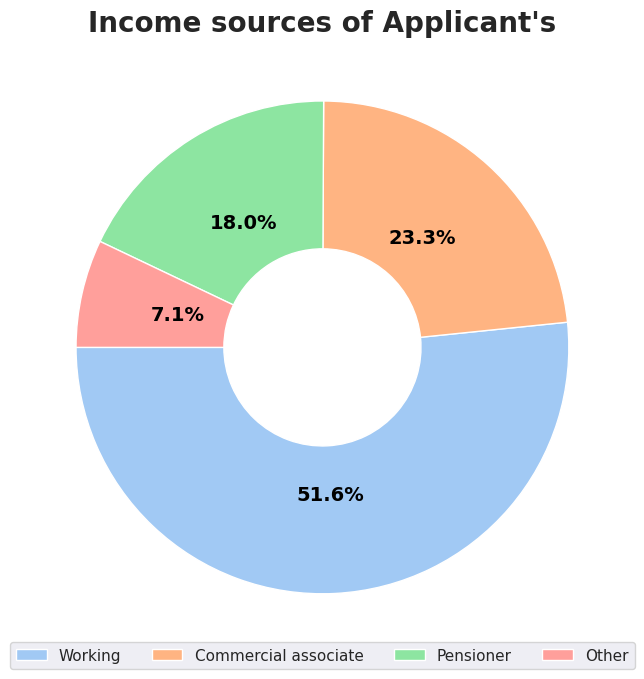

In [39]:
# Assuming df_application_train is your DataFrame
temp = df_application_train["NAME_INCOME_TYPE"].value_counts()

# Select the top 4 categories
top_categories = temp.head(3)

# Create a new category for the rest
other_category = pd.Series(temp[3:].sum(), index=['Other'])

# Concatenate the top categories and the 'Other' category
new_temp = pd.concat([top_categories, other_category])

# Create a pie chart using Matplotlib with Seaborn styling
plt.figure(figsize=(8, 8))
plt.pie(new_temp, labels=None, autopct='%1.1f%%', startangle=180, wedgeprops=dict(width=0.6), colors=sns.color_palette("pastel"), textprops=textprops)
plt.title("Income sources of Applicant's", weight='bold', fontsize=20)
# Display the legend in one row with five columns
plt.legend(new_temp.index, loc='center', ncol=5, bbox_to_anchor=(0.5, 0))
# Use Seaborn styling
sns.set()

# Show the plot
plt.show()

7. Family Status of applicant's

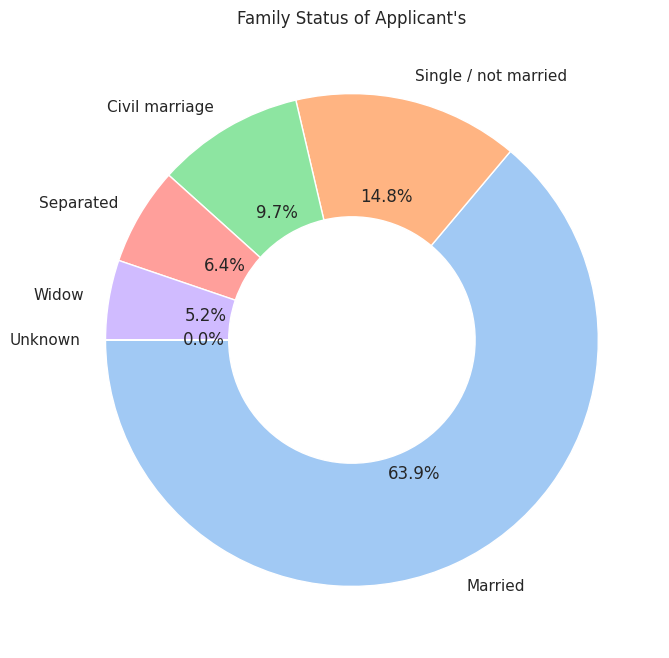

In [40]:
# Assuming application_train is your DataFrame
temp = df_application_train["NAME_FAMILY_STATUS"].value_counts()

# Set up the figure with subplots
fig, ax = plt.subplots(figsize=(8, 8))

# Plot a pie chart using Seaborn
ax.pie(temp, labels=temp.index, autopct='%1.1f%%', startangle=180, wedgeprops=dict(width=0.5),  colors=sns.color_palette("pastel"))

# Set title
plt.title("Family Status of Applicant's")

# Show the plot
plt.show()

8. Occupation of applicant's

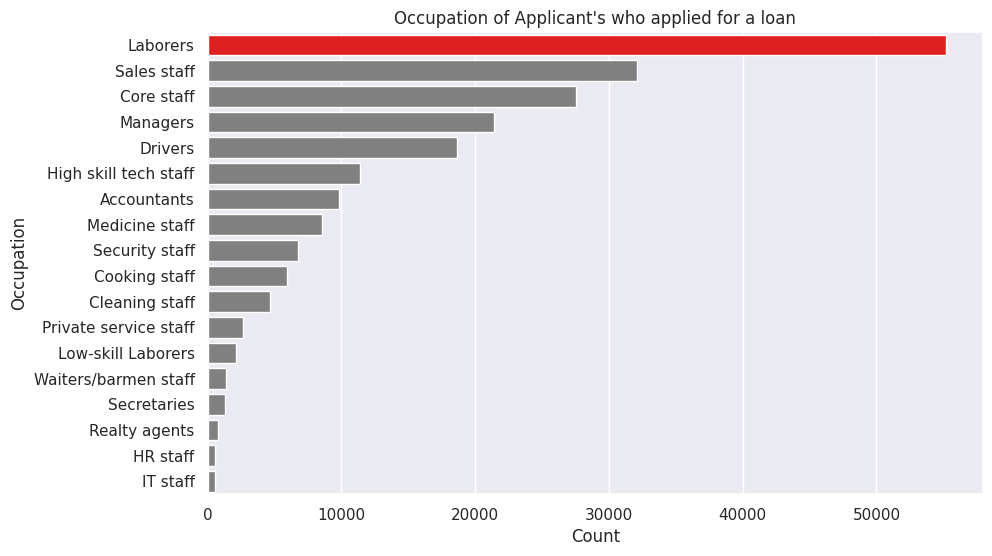

In [41]:
# Assuming application_train is your DataFrame
temp = df_application_train["OCCUPATION_TYPE"].value_counts()

# Set up the figure with Seaborn styling
plt.figure(figsize=(10, 6))
# Use a different color for the first bar and gray for the rest
colors = ['red'] + ['gray'] * (len(temp) - 1)

sns.barplot(y=temp.index, x=temp.values, palette=colors)
# Set labels and title
plt.ylabel('Occupation')
plt.xlabel('Count')
plt.title("Occupation of Applicant's who applied for a loan")

# Show the plot
plt.show()

Top Applicant's who applied for loan :
- Laborers: Approximately 55k applicants
- Sales Staff: Approximately 32k applicants
- Core Staff: Approximately 27,5k applicants
- Managers: Approximately 21,3k applicants
- Drivers: Approximately 18,6k applicants

9. Education of Applicant's

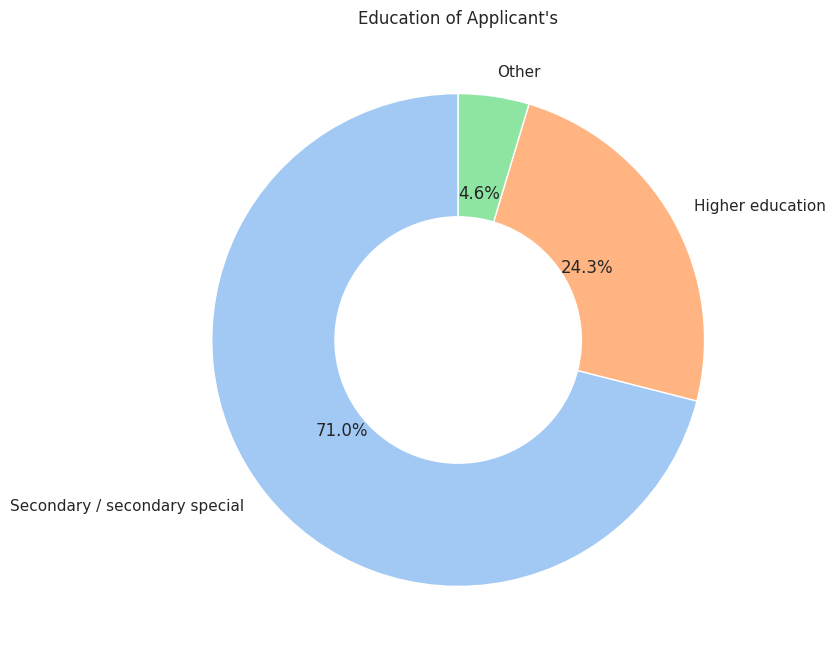

In [42]:
# Assuming application_train is your DataFrame
temp = df_application_train["NAME_EDUCATION_TYPE"].value_counts()

# Select the top categories (e.g., top 4)
top_categories = temp.head(2)

# Create a new category for the rest
other_category = pd.Series(temp[2:].sum(), index=['Other'])

# Concatenate the top categories and the 'Other' category
new_temp = pd.concat([top_categories, other_category])

# Set up the figure with Seaborn styling
plt.figure(figsize=(8, 8))
sns.set_palette("pastel")
plt.pie(new_temp, labels=new_temp.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.5))

# Set title
plt.title("Education of Applicant's")

# Show the plot
plt.show()

- 71 % applicants have secondary and 24.3 % having higher education.

10.  For which types of house higher applicant's applied for loan ?

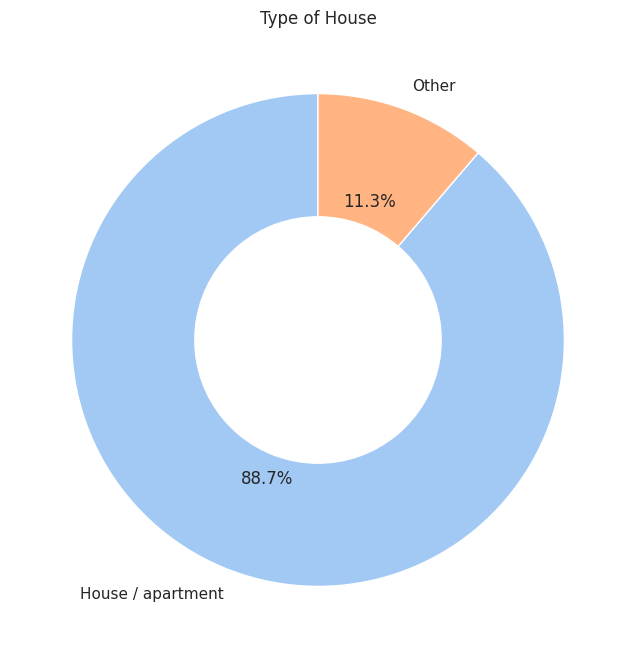

In [43]:
# Assuming application_train is your DataFrame
temp = df_application_train["NAME_HOUSING_TYPE"].value_counts()

# Select the top categories (e.g., top 4)
top_categories = temp.head(1)

# Create a new category for the rest
other_category = pd.Series(temp[1:].sum(), index=['Other'])

# Concatenate the top categories and the 'Other' category
new_temp = pd.concat([top_categories, other_category])

# Set up the figure with Seaborn styling
plt.figure(figsize=(8, 8))
sns.set_palette("pastel")
plt.pie(new_temp, labels=new_temp.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.5))

# Set title
plt.title("Type of House")

# Show the plot
plt.show()

- Approximately 88.7 % peoples applied for loan, they mentioned type of house is **House / Appartment**.

##### Analysis Bivariat

1. Income sources of Applicant's in terms of loan is repayed or not in %

<Figure size 1200x800 with 0 Axes>

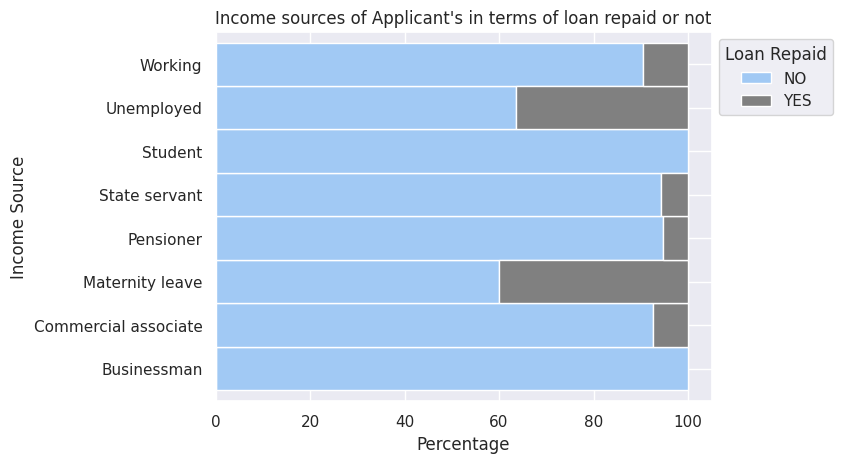

In [44]:
# Assuming df_application_train is your DataFrame
temp = df_application_train["NAME_INCOME_TYPE"].value_counts()

# Create a DataFrame with percentages
temp_df = pd.crosstab(df_application_train["NAME_INCOME_TYPE"], df_application_train["TARGET"], normalize="index") * 100
colors = ['#a1c9f4', 'gray']
# Plot the bar chart
plt.figure(figsize=(12, 8))
ax = temp_df.plot(kind='barh', stacked=True, color=colors, width=1)

# Set labels and title
plt.ylabel('Income Source')
plt.xlabel('Percentage')
plt.title("Income sources of Applicant's in terms of loan repaid or not")

# Place legend outside the plot
plt.legend(title='Loan Repaid', labels=['NO', 'YES'], bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

2. Family Status of Applicant's in terms of loan is repayed or not in %

<Figure size 1200x800 with 0 Axes>

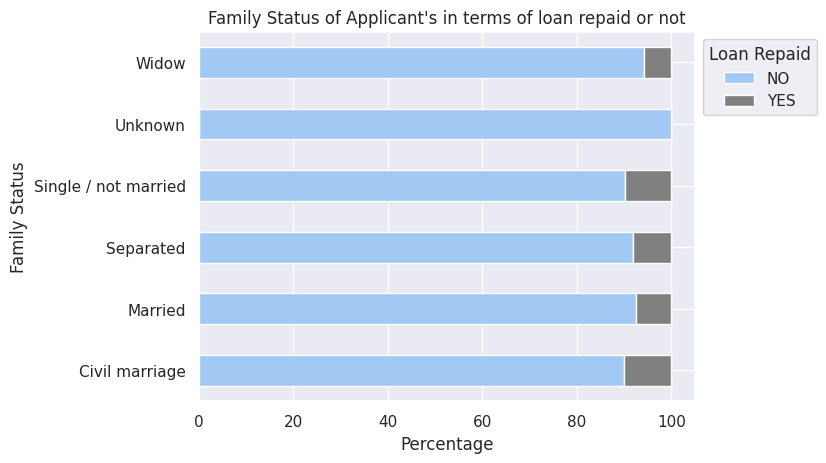

In [45]:
# Assuming df_application_train is your DataFrame
temp = df_application_train["NAME_FAMILY_STATUS"].value_counts()

# Create a DataFrame with percentages
temp_df = pd.crosstab(df_application_train["NAME_FAMILY_STATUS"], df_application_train["TARGET"], normalize="index") * 100
colors = ['#a1c9f4', 'gray']
# Plot the bar chart
plt.figure(figsize=(12, 8))
ax = temp_df.plot(kind='barh', stacked=True, color=colors)

# Set labels and title
plt.xlabel('Percentage')
plt.ylabel('Family Status')
plt.title("Family Status of Applicant's in terms of loan repaid or not")

# Place legend outside the plot
ax.legend(title='Loan Repaid', labels=['NO', 'YES'], bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

3. Education of Applicant's in terms of loan is repayed or not in %

<Figure size 1200x800 with 0 Axes>

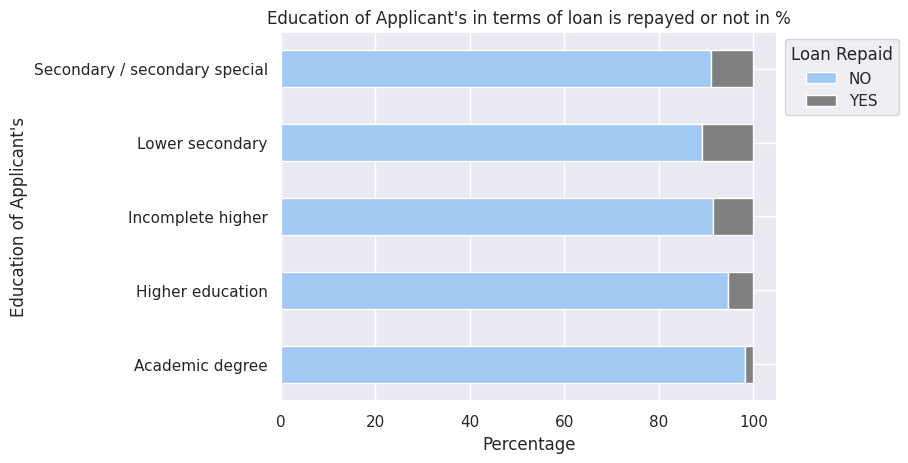

In [46]:
# Assuming df_application_train is your DataFrame
temp = df_application_train["NAME_EDUCATION_TYPE"].value_counts()

# Create a DataFrame with percentages
temp_df = pd.crosstab(df_application_train["NAME_EDUCATION_TYPE"], df_application_train["TARGET"], normalize="index") * 100
colors = ['#a1c9f4', 'gray']
# Plot the bar chart
plt.figure(figsize=(12, 8))
ax = temp_df.plot(kind='barh', stacked=True, color=colors)

# Set labels and title
plt.ylabel('Education of Applicant\'s')
plt.xlabel('Percentage')
plt.title("Education of Applicant's in terms of loan is repayed or not in %")

# Place legend outside the plot
plt.legend(title='Loan Repaid', labels=['NO', 'YES'], bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

4. For which types of house higher applicant's applied for loan in terms of loan is repayed or not in %

<Figure size 1200x800 with 0 Axes>

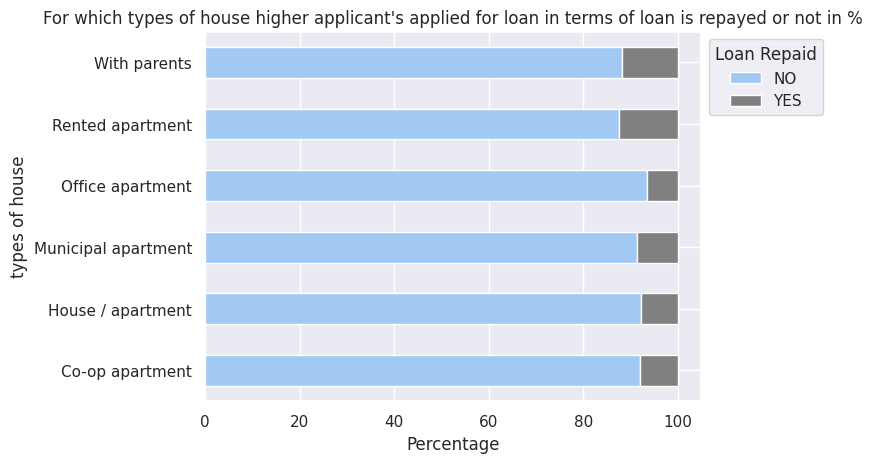

In [47]:
# Assuming df_application_train is your DataFrame
temp = df_application_train["NAME_HOUSING_TYPE"].value_counts()

# Create a DataFrame with percentages
temp_df = pd.crosstab(df_application_train["NAME_HOUSING_TYPE"], df_application_train["TARGET"], normalize="index") * 100
colors = ['#a1c9f4', 'gray']
# Plot the bar chart
plt.figure(figsize=(12, 8))
ax = temp_df.plot(kind='barh', stacked=True, color=colors)

# Set labels and title
plt.ylabel('types of house')
plt.xlabel('Percentage')
plt.title("For which types of house higher applicant's applied for loan in terms of loan is repayed or not in %")

# Place legend outside the plot
plt.legend(title='Loan Repaid', labels=['NO', 'YES'], bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

5. Distribution of age of clients

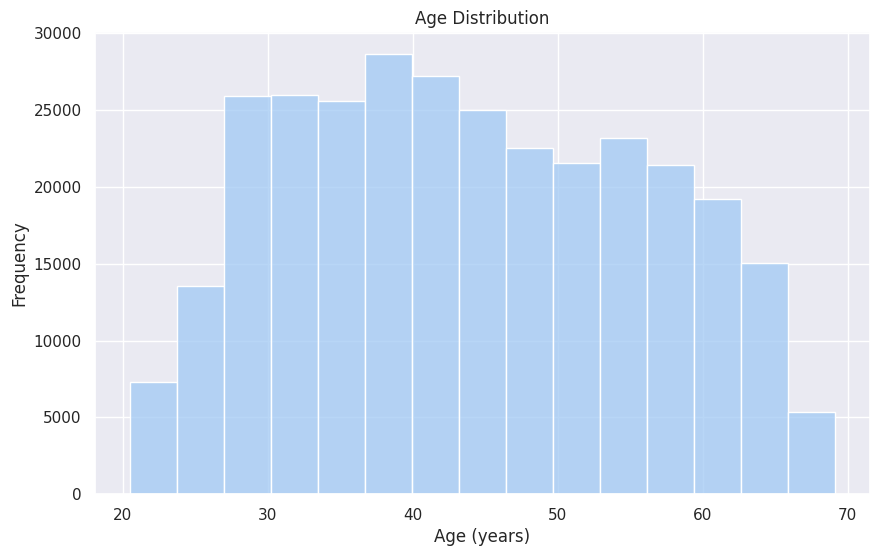

In [48]:
# Konversi DAYS_BIRTH ke tahun dan ambil nilai absolut
df_application_train['Age'] = np.abs(df_application_train['DAYS_BIRTH']) / 365
df_application_test['Age'] = np.abs(df_application_test['DAYS_BIRTH']) / 365
# Buat histogram menggunakan seaborn
plt.figure(figsize=(10, 6))
sns.histplot(df_application_train['Age'], bins=15, kde=False)
plt.title('Age Distribution')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.show()

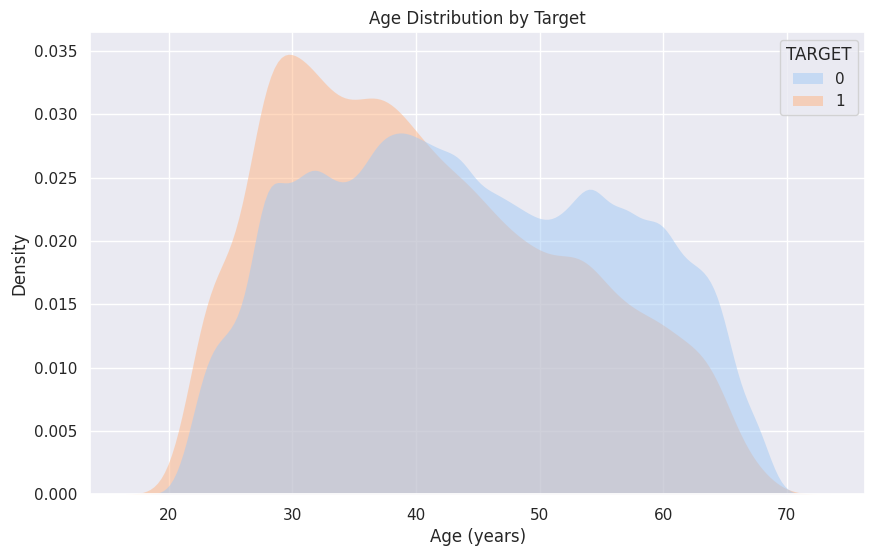

In [49]:
# Buat plot distribusi menggunakan seaborn
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_application_train, x='Age', hue='TARGET', common_norm=False, fill=True, alpha=0.5, linewidth=0)
plt.title('Age Distribution by Target')
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.show()

6. Distribution of EXT_SOURCE_1 by target

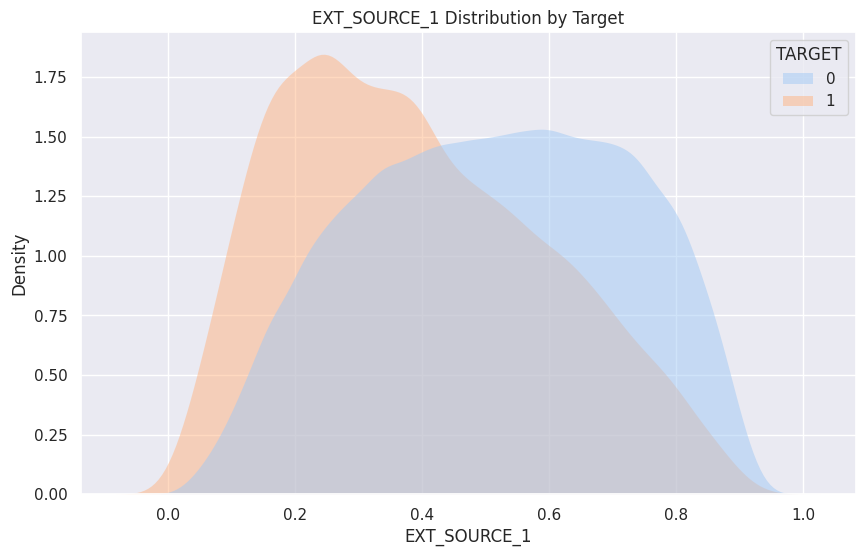

In [50]:
# Buat plot distribusi menggunakan seaborn
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_application_train, x='EXT_SOURCE_1', hue='TARGET', common_norm=False, fill=True, alpha=0.5, linewidth=0)
plt.title('EXT_SOURCE_1 Distribution by Target')
plt.xlabel('EXT_SOURCE_1')
plt.ylabel('Density')
plt.show()

7. Distribution of EXT_SOURCE_2 by target

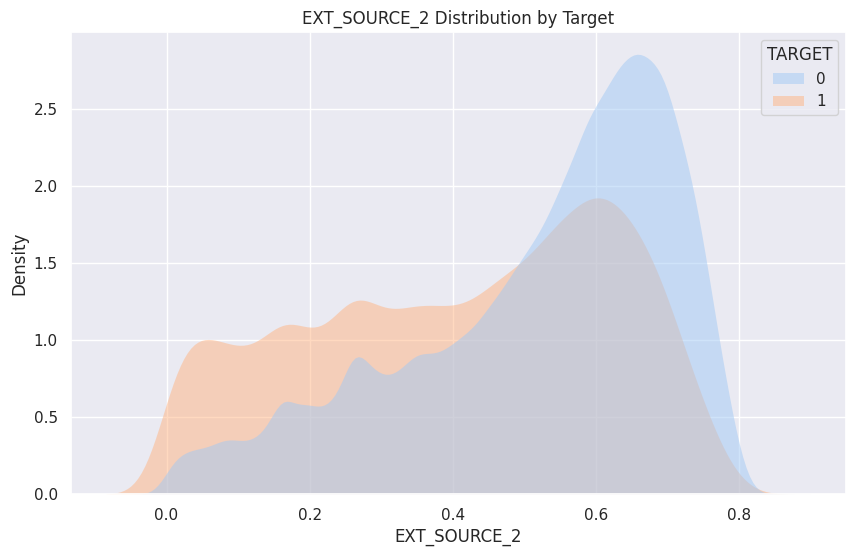

In [51]:
# Buat plot distribusi menggunakan seaborn
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_application_train, x='EXT_SOURCE_2', hue='TARGET', common_norm=False, fill=True, alpha=0.5, linewidth=0)
plt.title('EXT_SOURCE_2 Distribution by Target')
plt.xlabel('EXT_SOURCE_2')
plt.ylabel('Density')
plt.show()

8. Distribution of EXT_SOURCE_3 by target

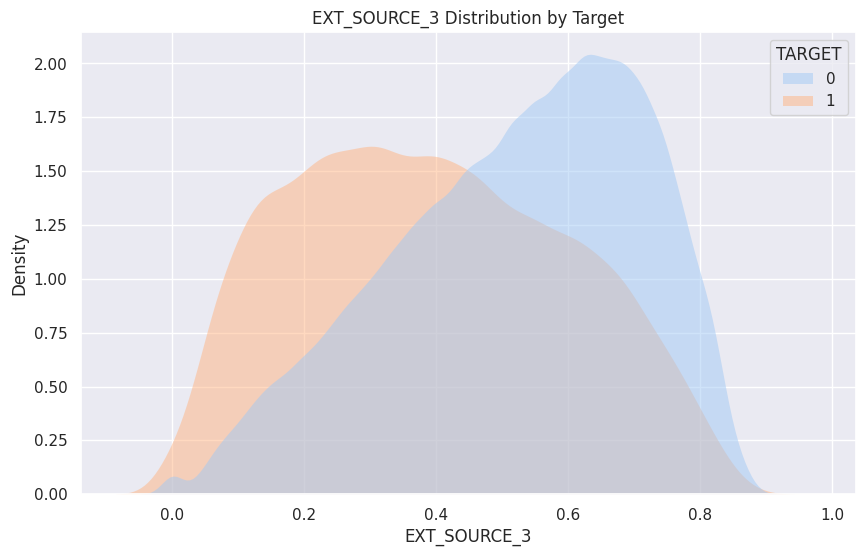

In [52]:
# Buat plot distribusi menggunakan seaborn
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_application_train, x='EXT_SOURCE_3', hue='TARGET', common_norm=False, fill=True, alpha=0.5, linewidth=0)
plt.title('EXT_SOURCE_3 Distribution by Target')
plt.xlabel('EXT_SOURCE_3')
plt.ylabel('Density')
plt.show()

##### Exploration of previous application data

1. Contract product type of previous application

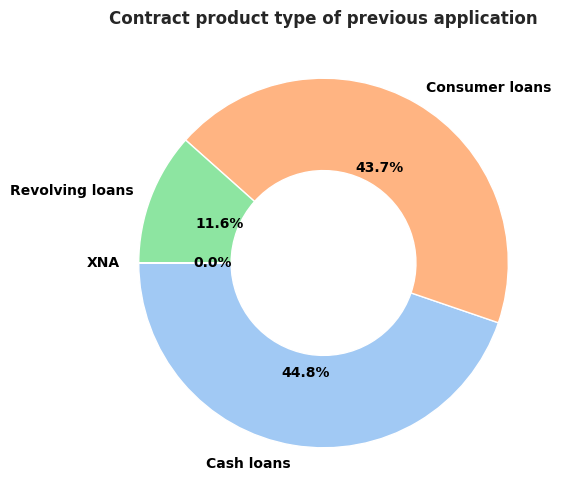

In [53]:
# Assuming application_train is your DataFrame
temp = df_previous_application["NAME_CONTRACT_TYPE"].value_counts()

# Create a pie chart using Matplotlib with Seaborn styling
plt.figure(figsize=(6, 6))
plt.pie(temp, labels=temp.index, autopct='%1.1f%%', colors=sns.color_palette("pastel"), startangle=180, wedgeprops=dict(width=0.5), textprops={'color': 'black', 'weight': 'bold', 'fontsize': 10})
plt.title("Contract product type of previous application", weight='bold')  # Clear default title
# plt.legend(temp.index)
# Add a title in the center of the donut chart
# plt.text(0, 0, "Contract Types", ha='center', va='center', fontsize=16, fontweight='bold')

plt.show()

2. On which day highest number of clients applied in previous application

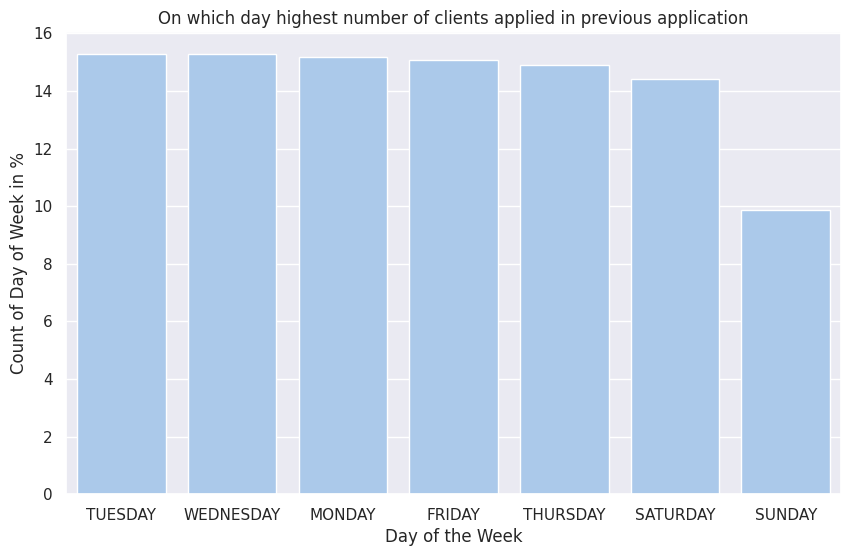

In [54]:
# Assuming previous_application is your DataFrame
temp = df_previous_application["WEEKDAY_APPR_PROCESS_START"].value_counts()

# Calculate the percentage of each day of the week
percentage = (temp / temp.sum()) * 100

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=percentage.index, y=percentage.values, color=colors[0])

# Set labels and title
plt.xlabel('Day of the Week')
plt.ylabel('Count of Day of Week in %')
plt.title('On which day highest number of clients applied in previous application')

# Show the plot
plt.show()

- What a coincedence, Approximately 15 % clients applied in each 5 days a week i.e, Tuesday, Wednesday, Monday, Friday and Thrusday.

3. Contract was approved or not in previous application

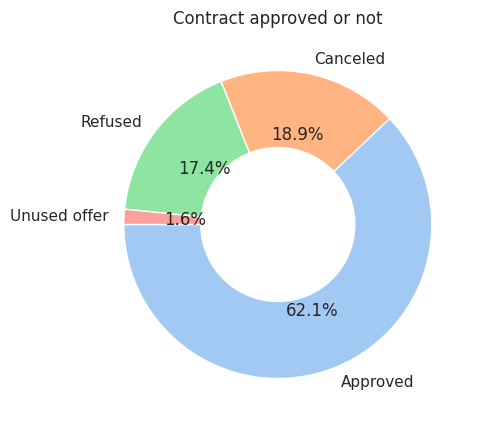

In [55]:
temp = df_previous_application["NAME_CONTRACT_STATUS"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
# Set the style to use Seaborn's style
sns.set(style="whitegrid")

# Create a pie chart using Seaborn and Matplotlib
plt.figure(figsize=(5, 5))
plt.pie(df['values'], labels=df['labels'], autopct='%1.1f%%', startangle=180, wedgeprops=dict(width=0.5), colors=sns.color_palette("pastel"))
plt.title('Contract approved or not')

# Show the plot
plt.show()

Contract was approved or not in previous application :
- Approved : 62.1 % times
- Cancelled : 18.9 % times
- Refused : 17.4 % times
- Unused offer : 1.58 % times

4. Why was the previous application rejected ?

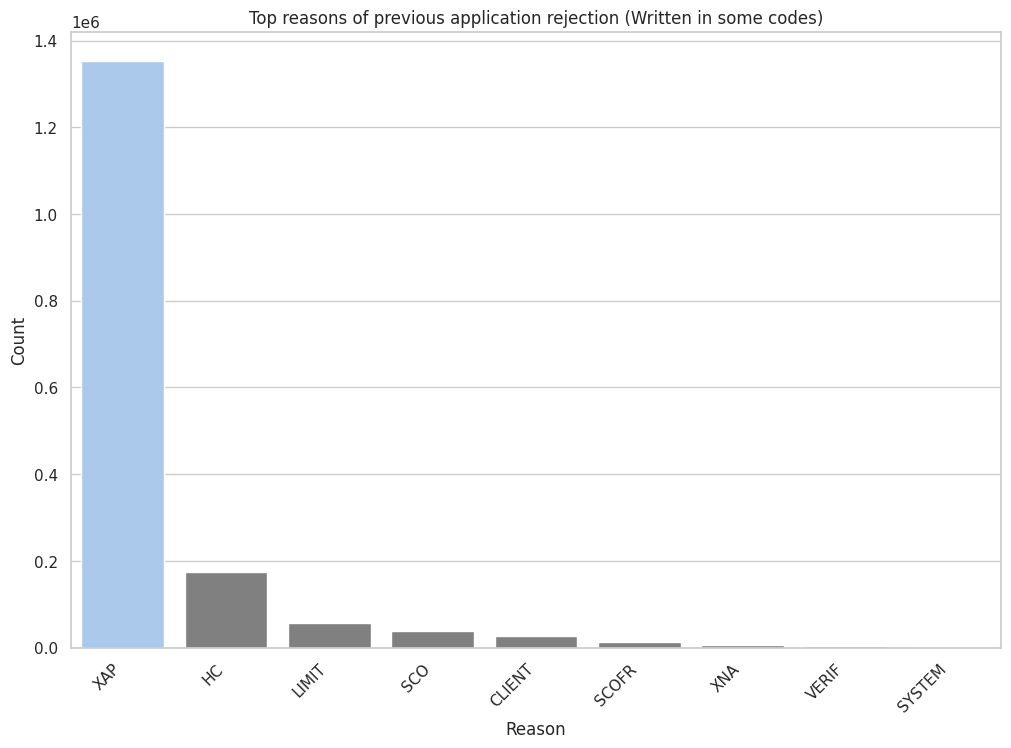

In [56]:
# Assuming previous_application is your DataFrame
temp = df_previous_application["CODE_REJECT_REASON"].value_counts()

# Set the style to use Seaborn's style
sns.set(style="whitegrid")
colors_palette = ['#a1c9f4'] + (['gray'] * (len(temp) - 1))
# Create a bar plot using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x=temp.index, y=temp.values, palette=colors_palette)

# Set labels and title
plt.xlabel('Reason')
plt.ylabel('Count')
plt.title('Top reasons of previous application rejection (Written in some codes)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

5. Was the client old or new client when applying for the previous application

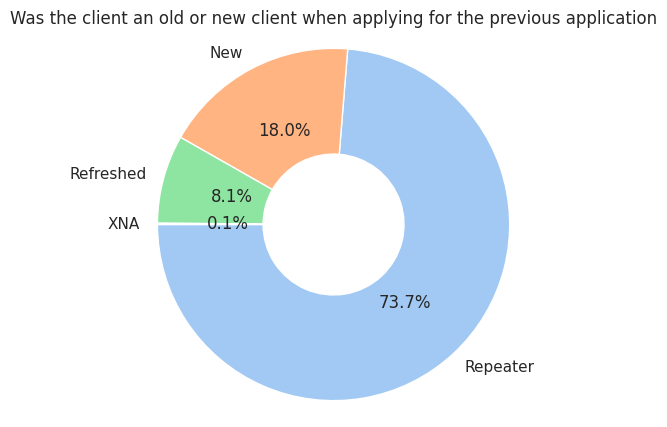

In [57]:
temp = df_previous_application["NAME_CLIENT_TYPE"].value_counts()

# Create a DataFrame for plotting
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values})

# Set the style to use Seaborn's style
sns.set(style="whitegrid")

# Create a pie chart using Seaborn with custom colors
plt.figure(figsize=(5, 5))
plt.pie(df['values'], labels=df['labels'], autopct='%1.1f%%', startangle=180, wedgeprops=dict(width=0.6), colors=sns.color_palette('pastel'))
plt.title('Was the client an old or new client when applying for the previous application')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()

- Approximately 73.7 % was repeater clients who applied for previous application.

#### Cleaning Data

In [58]:
def get_columns_to_drop(df, threshold_percentage=50):
    """
    Mengembalikan daftar kolom yang akan dihapus berdasarkan kondisi persentase nilai null.

    Parameters:
    - df (pd.DataFrame): DataFrame yang akan dianalisis.
    - threshold_percentage (float): Persentase batas di atasnya kolom akan dihapus.

    Returns:
    - List: Daftar nama kolom yang akan dihapus.
    """
    total_rows = len(df)
    null_percentages = (df.isnull().sum() / total_rows) * 100

    columns_to_drop = null_percentages[null_percentages > threshold_percentage].index.tolist()

    return columns_to_drop

def drop_columns(df, columns_to_drop):
    df_cleaned = df.drop(columns=columns_to_drop)
    return df_cleaned

In [59]:
# Replacing XNA in columns GENDER and ORGANIZATION_TYPE to NaN
df_application_train.CODE_GENDER.replace("XNA", np.nan, inplace=True)
df_application_train.ORGANIZATION_TYPE.replace("XNA", np.nan, inplace=True)

# df_application_test.CODE_GENDER.replace("XNA", np.nan, inplace=True)
df_application_test.ORGANIZATION_TYPE.replace("XNA", np.nan, inplace=True)

##### aplication test and train

In [60]:
drop_app_train = get_columns_to_drop(df_application_train)
df_application_train = drop_columns(df_application_train, drop_app_train)

df_application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,25.920548
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,45.931507
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,52.180822
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,52.068493
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,54.608219


In [61]:
# Pisahkan kolom-kolom numerik dan objek
numeric_columns = df_application_train.select_dtypes(include=['float', 'int']).columns
object_columns = df_application_train.select_dtypes(include=['object']).columns

# Isi nilai NaN untuk kolom numerik dengan mean
df_application_train[numeric_columns] = df_application_train[numeric_columns].fillna(df_application_train[numeric_columns].median())

# Isi nilai NaN untuk kolom objek dengan mode
df_application_train[object_columns] = df_application_train[object_columns].apply(lambda col: col.fillna(col.mode()[0]))

# Hitung total nilai yang hilang setelah pengisian
df_application_train.isnull().sum().sum()

0

In [62]:
df_application_test = drop_columns(df_application_test, drop_app_train)
df_application_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,52.715068
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,49.490411
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0,54.898630
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,38.290411
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,35.726027


In [63]:
# Pisahkan kolom-kolom numerik dan objek
numeric_columns = df_application_test.select_dtypes(include=['float', 'int']).columns
object_columns = df_application_test.select_dtypes(include=['object']).columns

# Isi nilai NaN untuk kolom numerik dengan mean
df_application_test[numeric_columns] = df_application_test[numeric_columns].fillna(df_application_test[numeric_columns].median())

# Isi nilai NaN untuk kolom objek dengan mode
df_application_test[object_columns] = df_application_test[object_columns].apply(lambda col: col.fillna(col.mode()[0]))

# Hitung total nilai yang hilang setelah pengisian
df_application_test.isnull().sum().sum()

0

##### bureau

In [64]:
drop_bureau = get_columns_to_drop(df_bureau)
df_bureau = drop_columns(df_bureau, drop_bureau)

df_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,0,91323.0,0.0,NaN,0.0,Consumer credit,-131
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21


In [65]:
# Pisahkan kolom-kolom numerik dan objek
numeric_columns = df_bureau.select_dtypes(include=['float', 'int']).columns
object_columns = df_bureau.select_dtypes(include=['object']).columns

# Isi nilai NaN untuk kolom numerik dengan mean
df_bureau[numeric_columns] = df_bureau[numeric_columns].fillna(df_bureau[numeric_columns].median())

# Isi nilai NaN untuk kolom objek dengan mode
df_bureau[object_columns] = df_bureau[object_columns].apply(lambda col: col.fillna(col.mode()[0]))

# Hitung total nilai yang hilang setelah pengisian
df_bureau.isnull().sum().sum()

0

##### credit card balance

In [66]:
# Pisahkan kolom-kolom numerik dan objek
numeric_columns = df_credit_card_balance.select_dtypes(include=['float', 'int']).columns
object_columns = df_credit_card_balance.select_dtypes(include=['object']).columns

# Isi nilai NaN untuk kolom numerik dengan mean
df_credit_card_balance[numeric_columns] = df_credit_card_balance[numeric_columns].fillna(df_credit_card_balance[numeric_columns].median())

# Isi nilai NaN untuk kolom objek dengan mode
df_credit_card_balance[object_columns] = df_credit_card_balance[object_columns].apply(lambda col: col.fillna(col.mode()[0]))

# Hitung total nilai yang hilang setelah pengisian
df_credit_card_balance.isnull().sum().sum()

0

##### installments payments

In [67]:
# Pisahkan kolom-kolom numerik dan objek
numeric_columns = df_installments_payments.select_dtypes(include=['float', 'int']).columns
object_columns = df_installments_payments.select_dtypes(include=['object']).columns

# Isi nilai NaN untuk kolom numerik dengan mean
df_installments_payments[numeric_columns] = df_installments_payments[numeric_columns].fillna(df_installments_payments[numeric_columns].median())

# Isi nilai NaN untuk kolom objek dengan mode
df_installments_payments[object_columns] = df_installments_payments[object_columns].apply(lambda col: col.fillna(col.mode()[0]))

# Hitung total nilai yang hilang setelah pengisian
df_installments_payments.isnull().sum().sum()

0

##### previous application

In [68]:
drop_previous_app = get_columns_to_drop(df_previous_application)
df_previous_application = drop_columns(df_previous_application, drop_previous_app)

df_previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,17145.0,SATURDAY,15,Y,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,607500.0,THURSDAY,11,Y,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,112500.0,TUESDAY,11,Y,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,450000.0,MONDAY,7,Y,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,337500.0,THURSDAY,9,Y,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
# Pisahkan kolom-kolom numerik dan objek
numeric_columns = df_previous_application.select_dtypes(include=['float', 'int']).columns
object_columns = df_previous_application.select_dtypes(include=['object']).columns

# Isi nilai NaN untuk kolom numerik dengan mean
df_previous_application[numeric_columns] = df_previous_application[numeric_columns].fillna(df_previous_application[numeric_columns].mean())

# Isi nilai NaN untuk kolom objek dengan mode
df_previous_application[object_columns] = df_previous_application[object_columns].apply(lambda col: col.fillna(col.mode()[0]))

# Hitung total nilai yang hilang setelah pengisian
df_previous_application.isnull().sum().sum()

0

##### posh cash balance

In [70]:
# Pisahkan kolom-kolom numerik dan objek
numeric_columns = df_pos_cash_balance.select_dtypes(include=['float', 'int']).columns
object_columns = df_pos_cash_balance.select_dtypes(include=['object']).columns

# Isi nilai NaN untuk kolom numerik dengan mean
df_pos_cash_balance[numeric_columns] = df_pos_cash_balance[numeric_columns].fillna(df_pos_cash_balance[numeric_columns].median())

# Isi nilai NaN untuk kolom objek dengan mode
df_pos_cash_balance[object_columns] = df_pos_cash_balance[object_columns].apply(lambda col: col.fillna(col.mode()[0]))

# Hitung total nilai yang hilang setelah pengisian
df_pos_cash_balance.isnull().sum().sum()

0

#### merge all data

In [71]:
prev_app = df_previous_application.groupby(['SK_ID_CURR'])['SK_ID_CURR'].agg(['count']).reset_index()
prev_app.columns = ['SK_ID_CURR','TOTAL_PREV_APP']
prev_app

,SK_ID_CURR,TOTAL_PREV_APP
0,100001,1
1,100002,1
2,100003,3
3,100004,1
4,100005,2
...,...,...
338852,456251,1
338853,456252,1
338854,456253,2
338855,456254,2


In [72]:
bureau_cred = df_bureau.groupby(['SK_ID_CURR'])['SK_ID_CURR'].agg(['count']).reset_index()
bureau_cred.columns = ['SK_ID_CURR','TOTAL_BUREAU_LOAN']
bureau_cred

,SK_ID_CURR,TOTAL_BUREAU_LOAN
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3
...,...,...
305806,456249,13
305807,456250,3
305808,456253,4
305809,456254,1


In [73]:
df_main_train = df_application_train.merge(prev_app, how='left', on='SK_ID_CURR')

In [74]:
df_main_train = df_main_train.merge(bureau_cred, how='left', on='SK_ID_CURR')

In [75]:
df_main_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age,TOTAL_PREV_APP,TOTAL_BUREAU_LOAN
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0.0,0.0,0.0,0.0,0.0,1.0,25.920548,1.0,8.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0.0,0.0,0.0,0.0,0.0,0.0,45.931507,3.0,4.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,52.180822,1.0,2.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0.0,0.0,0.0,0.0,0.0,1.0,52.068493,9.0,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0.0,0.0,0.0,0.0,0.0,0.0,54.608219,6.0,1.0


In [76]:
df_main_test = df_application_test.merge(prev_app, how='left', on='SK_ID_CURR')

In [77]:
df_main_test = df_main_test.merge(bureau_cred, how='left', on='SK_ID_CURR')

In [78]:
df_main_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age,TOTAL_PREV_APP,TOTAL_BUREAU_LOAN
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,52.715068,1.0,7.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0.0,0.0,0.0,0.0,0.0,3.0,49.490411,2.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0.0,0.0,0.0,0.0,1.0,4.0,54.898630,4.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0.0,0.0,0.0,0.0,0.0,3.0,38.290411,5.0,12.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0.0,0.0,0.0,0.0,0.0,2.0,35.726027,2.0,NaN


In [79]:
print('Shape train data : ', df_main_train.shape)
print('Shape test data : ', df_main_test.shape)

Shape train data :  (307511, 84)
Shape test data :  (48744, 83)


In [88]:
df_main_train.isnull().sum()

SK_ID_CURR                    0
TARGET                        0
NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
                             ..
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
Age                           0
TOTAL_PREV_APP                0
TOTAL_BUREAU_LOAN             0
Length: 84, dtype: int64

In [89]:
df_main_test.isnull().sum()

SK_ID_CURR                    0
NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
FLAG_OWN_REALTY               0
                             ..
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
Age                           0
TOTAL_PREV_APP                0
TOTAL_BUREAU_LOAN             0
Length: 83, dtype: int64

In [87]:
df_main_train = df_main_train.fillna(0)
df_main_test = df_main_test.fillna(0)

### Feature Engineering

In [91]:
#  Some simple new features (percentages)
df_main_train['DAYS_EMPLOYED_PERC'] = df_main_train['DAYS_EMPLOYED'] / df_main_train['DAYS_BIRTH']
df_main_train['INCOME_CREDIT_PERC'] = df_main_train['AMT_INCOME_TOTAL'] / df_main_train['AMT_CREDIT']
df_main_train['INCOME_PER_PERSON'] = df_main_train['AMT_INCOME_TOTAL'] / df_main_train['CNT_FAM_MEMBERS']
df_main_train['ANNUITY_INCOME_PERC'] = df_main_train['AMT_ANNUITY'] / df_main_train['AMT_INCOME_TOTAL']
df_main_train['PAYMENT_RATE'] = df_main_train['AMT_ANNUITY'] / df_main_train['AMT_CREDIT']

In [92]:
#  Some simple new features (percentages)
df_main_test['DAYS_EMPLOYED_PERC'] = df_main_test['DAYS_EMPLOYED'] / df_main_test['DAYS_BIRTH']
df_main_test['INCOME_CREDIT_PERC'] = df_main_test['AMT_INCOME_TOTAL'] / df_main_test['AMT_CREDIT']
df_main_test['INCOME_PER_PERSON'] = df_main_test['AMT_INCOME_TOTAL'] / df_main_test['CNT_FAM_MEMBERS']
df_main_test['ANNUITY_INCOME_PERC'] = df_main_test['AMT_ANNUITY'] / df_main_test['AMT_INCOME_TOTAL']
df_main_test['PAYMENT_RATE'] = df_main_test['AMT_ANNUITY'] / df_main_test['AMT_CREDIT']

In [93]:
# Scalling numerical features
def encoder(df):
    scaler = MinMaxScaler()
    numerical = df.select_dtypes(exclude=["object"]).columns
    numerical = numerical[1:]
    features_transform = pd.DataFrame(data=df)
    features_transform[numerical] = scaler.fit_transform(df[numerical])
    display(features_transform.head(n=5))
    return features_transform  # Return the scaled DataFrame

df_main_train_encode = encoder(df_main_train)
df_main_test_encode = encoder(df_main_test)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age,TOTAL_PREV_APP,TOTAL_BUREAU_LOAN,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,100002,1.0,Cash loans,M,N,Y,0.0,0.001512,0.090287,0.090032,...,0.0,0.04,0.111161,0.013699,0.068966,0.986282,0.002338,0.005121,0.064910,0.311054
1,100003,0.0,Cash loans,F,N,N,0.0,0.002089,0.311736,0.132924,...,0.0,0.00,0.522886,0.041096,0.034483,0.986355,0.000947,0.003390,0.070368,0.076481
2,100004,0.0,Revolving loans,M,Y,Y,0.0,0.000358,0.022472,0.020025,...,0.0,0.00,0.651466,0.013699,0.017241,0.985130,0.002347,0.001659,0.053193,0.234993
3,100006,0.0,Cash loans,F,N,Y,0.0,0.000935,0.066837,0.109477,...,0.0,0.04,0.649154,0.123288,0.000000,0.988201,0.002019,0.001659,0.117114,0.552994
4,100007,0.0,Cash loans,M,N,Y,0.0,0.000819,0.116854,0.078975,...,0.0,0.00,0.701409,0.082192,0.008621,0.988046,0.001082,0.003043,0.095823,0.182793


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age,TOTAL_PREV_APP,TOTAL_BUREAU_LOAN,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE
0,100001,Cash loans,F,N,Y,0.00,0.024654,0.238037,0.102453,0.184049,...,0.000000,0.000000,0.666573,0.012987,0.089744,0.985883,0.018973,0.013998,0.072596,0.091206
1,100005,Cash loans,M,N,Y,0.00,0.016440,0.080785,0.084558,0.061350,...,0.000000,0.176471,0.600661,0.025974,0.038462,0.988856,0.038186,0.009911,0.084064,0.267883
2,100013,Cash loans,M,Y,Y,0.00,0.040054,0.280965,0.378515,0.265849,...,0.142857,0.235294,0.711206,0.051948,0.051282,0.988269,0.025280,0.021661,0.167831,0.382899
3,100028,Cash loans,F,N,Y,0.10,0.065721,0.695297,0.262078,0.695297,...,0.000000,0.176471,0.371731,0.064935,0.153846,0.986177,0.015509,0.016553,0.074237,0.069983
4,100038,Cash loans,M,Y,N,0.05,0.034920,0.263804,0.166995,0.263804,...,0.000000,0.117647,0.319315,0.025974,0.000000,0.986988,0.023652,0.012295,0.085399,0.155070


In [94]:
def one_hot_encode(df):
    # Identify categorical columns
    categorical_cols = df.select_dtypes(include='object').columns

    # Apply One-Hot Encoding
    encoder = OneHotEncoder(sparse=False, drop='first')  # Use drop='first' to avoid the dummy variable trap for binary categories
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    return df_encoded

# Example usage
df_main_train_encode = one_hot_encode(df_main_train_encode)
df_main_test_encode = one_hot_encode(df_main_test_encode)

In [95]:
df_main_train_encode.dtypes.value_counts()

uint8      111
float64     75
int64        1
dtype: int64

In [96]:
df_main_test_encode.dtypes.value_counts()

uint8      109
float64     74
int64        1
dtype: int64

In [97]:
print('Shape train data : ', df_main_train_encode.shape)
print('Shape test data : ', df_main_test_encode.shape)

Shape train data :  (307511, 187)
Shape test data :  (48744, 184)


One-hot encoding menghasilkan kolom tambahan pada data latihan karena variabel kategorikal memiliki kategori yang tidak ada dalam data uji. Untuk mengatasi ketidaksesuaian ini, perlu dilakukan penyelarasan (alignment) antara kedua data frame.

In [98]:
# Selaraskan kedua DataFrame
df_main_train_encode, df_main_test_encode = df_main_train_encode.align(df_main_test_encode, join='left', axis=1, fill_value=0)

In [99]:
df_main_test_encode = df_main_test_encode.drop(columns='TARGET', axis=1)

In [100]:
print('Shape train data : ', df_main_train_encode.shape)
print('Shape test data : ', df_main_test_encode.shape)

Shape train data :  (307511, 187)
Shape test data :  (48744, 186)


In [104]:
df_main_train.isnull().sum().sum()

0

### Machine Learning Modelling

In [9]:
def eval_classification(model, xtrain, ytrain, xtest, ytest):
    # Prediksi menggunakan model pada set pengujian
    y_pred = model.predict(xtest)
    y_pred_proba = model.predict_proba(xtest)[:, 1]

    # Menampilkan metrik evaluasi
    print("Accuracy (Test Set): %.2f" % accuracy_score(ytest, y_pred))
    print("Precision (Test Set): %.2f" % precision_score(ytest, y_pred))
    print("Recall (Test Set): %.2f" % recall_score(ytest, y_pred))
    print("F1-Score (Test Set): %.2f" % f1_score(ytest, y_pred))

    fpr, tpr, thresholds = roc_curve(ytest, y_pred_proba, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print("AUC: %.2f" % roc_auc)

    # Plotting kurva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Contoh penggunaan:
# eval_classification(logres_tuning, X_train, y_train, X_test, y_test)


In [ ]:
df_main_train_encode.to_csv(folder_path + 'df_main_train_encode.csv')
df_main_test_encode.to_csv(folder_path + 'df_main_test_encode.csv')

In [7]:
df_main_train_encode = pd.read_csv(folder_path + 'df_main_train_encode.csv')

In [6]:
df_main_test_encode = pd.read_csv(folder_path + 'df_main_test_encode.csv')

#### LOGISTIC REGRESSION

In [8]:
# Pisahkan fitur (X) dan target (y)
X = df_main_train_encode.drop(columns=['TARGET','Unnamed: 0','SK_ID_CURR'], axis=1)
y = df_main_train_encode['TARGET']

# # Bagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy (Test Set): 0.81
Precision (Test Set): 0.16
Recall (Test Set): 0.34
F1-Score (Test Set): 0.22
AUC: 0.67


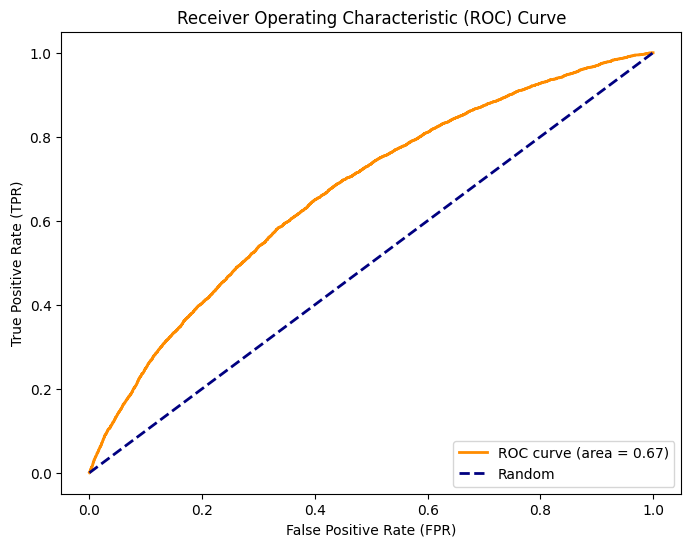

In [10]:
# Inisiasi SMOTE
smote = SMOTE(random_state=42)

# Melakukan oversampling pada data latihan
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Inisiasi model Regresi Logistik
logreg = LogisticRegression(random_state=42)

# Melatih model pada data latihan yang telah dioversampling
logreg.fit(X_train_resampled, y_train_resampled)

# Melakukan prediksi pada data pengujian
y_pred = logreg.predict(X_test)

# Evaluasi model pada set pengujian
eval_classification(logreg, X_train_resampled, y_train_resampled, X_test, y_test)

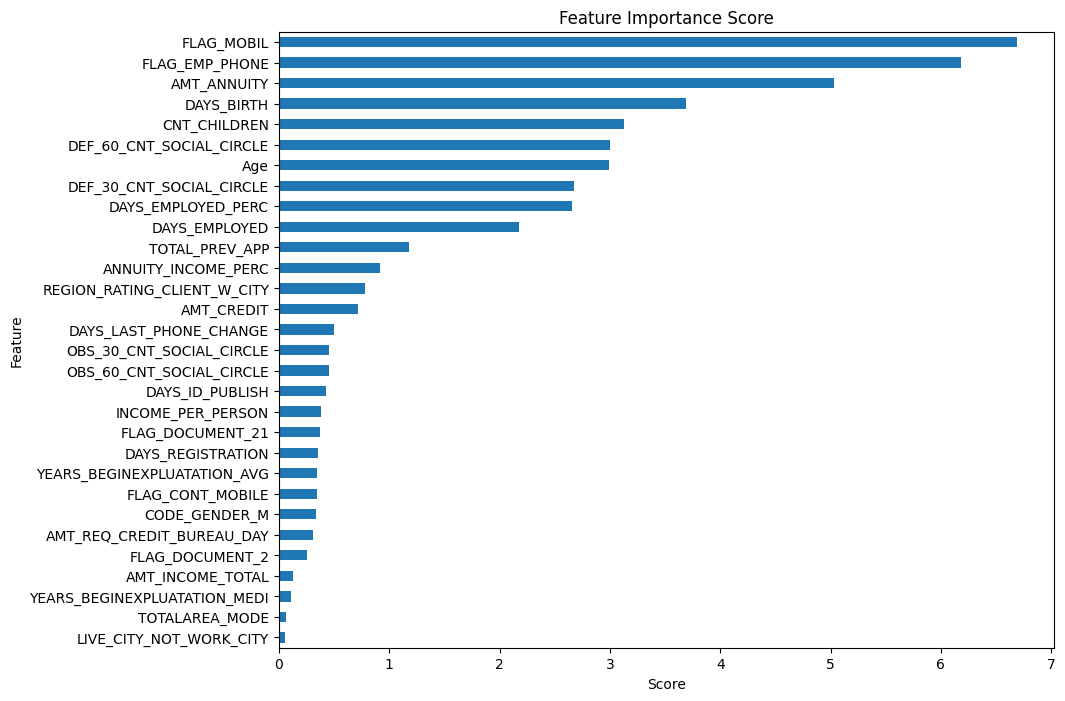

In [11]:
feat_importances = pd.Series(logreg.coef_[0], index=X.columns)
ax = feat_importances.nlargest(30).plot(kind='barh', figsize=(10, 8))
ax.invert_yaxis()

plt.xlabel('Score')
plt.ylabel('Feature')
plt.title('Feature Importance Score')
plt.show()

Hyperparameter tuning

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown i

Accuracy (Test Set): 0.78
Precision (Test Set): 0.16
Recall (Test Set): 0.42
F1-Score (Test Set): 0.23
AUC: 0.69


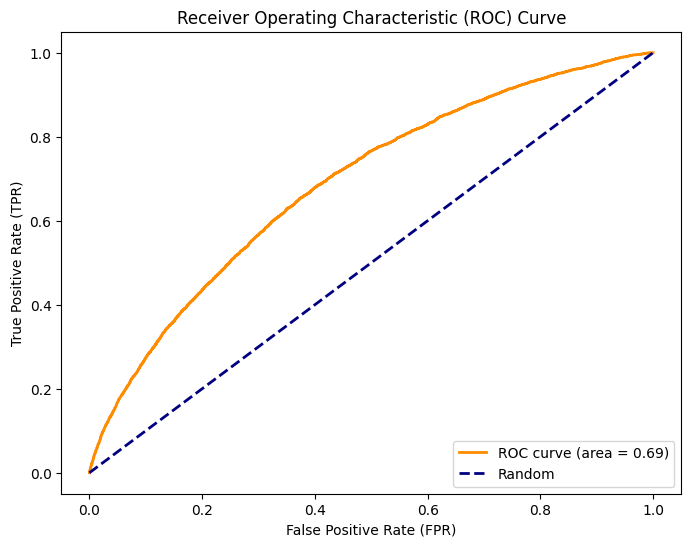

In [12]:
# List Hyperparameters yang akan diuji
penalty = ['l2', 'l1', 'elasticnet']
C = [0.0001, 0.005]  # Inverse of regularization strength; smaller values specify stronger regularization.
hyperparameters = dict(penalty=penalty, C=C)

# Inisiasi model Regresi Logistik
logres = LogisticRegression(random_state=42)

# Melakukan RandomizedSearchCV pada data yang telah dioversampling
logres_tuning = RandomizedSearchCV(logres, hyperparameters, cv=5, random_state=42, scoring='roc_auc')
logres_tuning.fit(X_train_resampled, y_train_resampled)

# Evaluasi model pada set pengujian
eval_classification(logres_tuning, X_train_resampled, y_train_resampled, X_test, y_test)

In [13]:
print('Best algorithm:', logres_tuning.best_estimator_.get_params()['penalty'])
print('Best C:', logres_tuning.best_estimator_.get_params()['C'])

Best algorithm: l2
Best C: 0.005


#### XGB CLASSIFIER

Accuracy: 0.9147358665430955
Precision: 0.4006734006734007
Recall: 0.12022630834512023
F1-Score: 0.18495492695057508


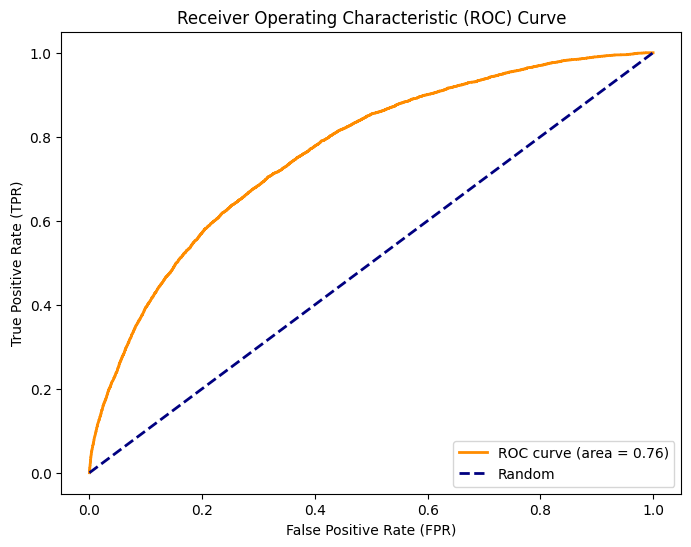

In [14]:
# Define XGBoost classifier with specified parameters
clf = XGBClassifier(
    learning_rate=0.01,
    n_estimators=10000,
    max_depth=4,
    min_child_weight=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=4,
    scale_pos_weight=2,
    seed=27
)

# Train the model
clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))

# Plotting ROC curve
y_pred_proba = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


#### CatBoost Classifier

Accuracy: 0.9102157618327561
Precision: 0.3325540619520748
Recall: 0.11497272176197211
F1-Score: 0.17087087087087086


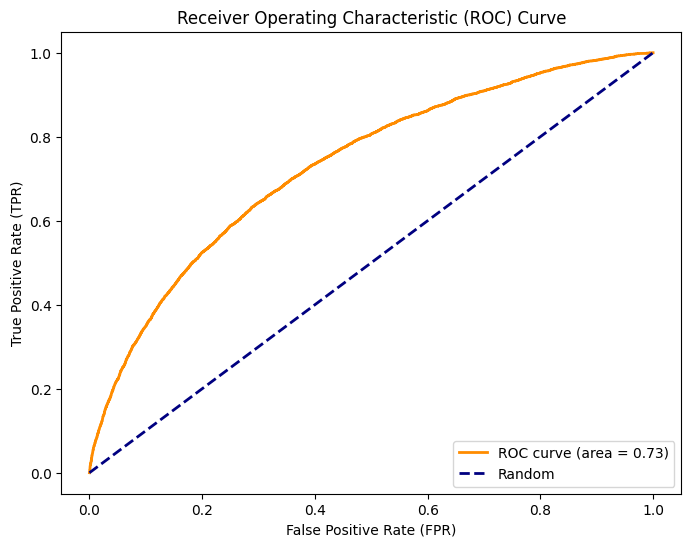

In [33]:
# Define CatBoost classifier with specified parameters
clf_cat = CatBoostClassifier(
    loss_function='Logloss',
    iterations=500,
    depth=8,
    class_weights=[1, 2],
    bootstrap_type='Bernoulli',
    random_seed=9,
    verbose=False
)

# Train the model
clf_cat.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))

# Plotting ROC curve
y_pred_proba = clf_cat.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


#### Testing

Logistic Regression

In [24]:
df_main_test_encode = df_main_test_encode.drop(columns=['Unnamed: 0','SK_ID_CURR'], axis=1)
# Make predictions on the test set
y_test_pred = logres_tuning.predict(df_main_test_encode)

# Print or use the predictions as needed
print("Test Predictions:", y_test_pred)

Test Predictions: [0. 1. 0. ... 0. 0. 0.]


In [25]:
unique_elements, counts = np.unique(y_test_pred, return_counts=True)

# Display the value counts
for element, count in zip(unique_elements, counts):
    print(f"{element}: {count} times")

0.0: 37719 times
1.0: 11025 times


XGBoost Classifier

In [27]:
# Make predictions on the test set
y_test_pred = clf.predict(df_main_test_encode)

# Print or use the predictions as needed
print("Test Predictions:", y_test_pred)

Test Predictions: [1 1 1 ... 1 1 1]


In [28]:
unique_elements, counts = np.unique(y_test_pred, return_counts=True)

# Display the value counts
for element, count in zip(unique_elements, counts):
    print(f"{element}: {count} times")

0: 484 times
1: 48260 times


CatBoost Classifier

In [34]:
# Make predictions on the test set
y_test_pred = clf_cat.predict(df_main_test_encode)

# Print or use the predictions as needed
print("Test Predictions:", y_test_pred)

Test Predictions: [1. 1. 1. ... 1. 1. 1.]


In [35]:
unique_elements, counts = np.unique(y_test_pred, return_counts=True)

# Display the value counts
for element, count in zip(unique_elements, counts):
    print(f"{element}: {count} times")

0.0: 3220 times
1.0: 45524 times


### Conclusion

1. Analisis hasil evaluasi model logistik regresi menunjukkan bahwa meskipun akurasi keseluruhan mencapai 78%, model memiliki tantangan dalam memprediksi secara konsisten antara kelas positif (default risk pada Home Credit) dan negatif (tidak default risk). Presisi yang rendah (16%) dan recall yang lebih tinggi (42%) menunjukkan bahwa model cenderung kesulitan mengidentifikasi dengan tepat kasus yang sebenarnya positif, dengan nilai AUC yang menengah (0.62). Ini memperlihatkan perlunya perhatian lebih lanjut untuk meningkatkan kinerja model, terutama dalam mengantisipasi risiko default pada Home Credit.

2. Evaluasi model XGBoost Classifier menunjukkan bahwa meskipun akurasinya tinggi (91%), model mengalami kesulitan dalam mengidentifikasi dengan tepat kasus positif (risiko default pada Home Credit) dengan nilai recall yang rendah (12%), sementara tingkat presisinya cukup (40%). Nilai F1-Score sebesar 18% mencerminkan keseimbangan antara presisi dan recall. Meski begitu, AUC dari Kurva ROC yang tinggi (0,76) menunjukkan kemampuan model dalam membedakan dengan baik antara kasus positif dan negatif. Dalam konteks risiko kredit Home Credit, perlu pertimbangan lebih lanjut untuk meningkatkan kemampuan model dalam mengenali kasus default dengan lebih akurat.

### Business Recomendation

- Conduct a campaign to attract the interest of potential applicants aged over 40.
- Launch a campaign that can attract the interest of those with high education.
- Be cautious with applicants who have a lower ext source 3, and seek out applicants with a high ext source 3.
- Provide special offers to applicants who apply on SUNDAY.
- Continuously engage with applicants to encourage repeated applications.
- Evaluate applicants who cancel and those with unused offers.

